In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [2]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Get:4 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]    
Get:5 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]       
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]      
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1724 kB]
Get:8 https://packages.cloud.google.com/apt google-fast-socket InRelease [1071 B]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]      
Err:4 http://packages.cloud.google.com/apt gcsfuse-focal InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY C0BA5CE6DC6315A3
Err:5 https://packages.cloud.google.com/apt cloud-sdk

# Importing Data 

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [3]:
#preparing data set

ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [4]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# preprocessing

**Ravdees**

In [5]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)
    

In [7]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: Emotions, dtype: in

**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [8]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: Emotions, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [9]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: Emotions, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

In [10]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


neutral     120
happy        60
fear         60
disgust      60
angry        60
surprise     60
sad          60
Name: Emotions, dtype: int64


**Integration**

In [11]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [12]:
print(data_path.Emotions.value_counts())


disgust     1923
fear        1923
sad         1923
happy       1923
angry       1923
neutral     1895
surprise     652
Name: Emotions, dtype: int64


>*                           Data Visualisation and Exploration

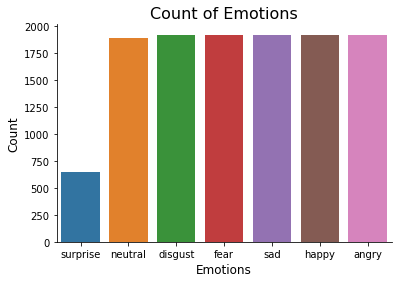

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Data augmentation

In [18]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# Feature extraction

In [24]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio


# Noraml way to get features

In [26]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)         

1it [00:00,  1.79it/s]

0 audio has been processed


501it [04:34,  1.82it/s]

500 audio has been processed


1001it [09:09,  1.79it/s]

1000 audio has been processed


1501it [13:35,  2.35it/s]

1500 audio has been processed


2001it [17:11,  2.34it/s]

2000 audio has been processed


2501it [20:51,  2.18it/s]

2500 audio has been processed


3001it [24:28,  2.28it/s]

3000 audio has been processed


3501it [28:06,  2.27it/s]

3500 audio has been processed


4001it [31:46,  2.29it/s]

4000 audio has been processed


4501it [35:25,  2.45it/s]

4500 audio has been processed


5001it [39:03,  2.32it/s]

5000 audio has been processed


5501it [42:40,  2.40it/s]

5500 audio has been processed


6001it [46:20,  2.16it/s]

6000 audio has been processed


6501it [50:00,  2.21it/s]

6500 audio has been processed


7001it [53:40,  2.24it/s]

7000 audio has been processed


7501it [57:22,  2.35it/s]

7500 audio has been processed


8001it [1:01:04,  2.38it/s]

8000 audio has been processed


8501it [1:04:46,  2.18it/s]

8500 audio has been processed


9001it [1:08:16,  2.95it/s]

9000 audio has been processed


9501it [1:11:01,  2.30it/s]

9500 audio has been processed


10001it [1:14:34,  2.45it/s]

10000 audio has been processed


10501it [1:18:23,  2.49it/s]

10500 audio has been processed


11001it [1:21:48,  2.50it/s]

11000 audio has been processed


11501it [1:25:15,  2.68it/s]

11500 audio has been processed


12001it [1:29:10,  1.87it/s]

12000 audio has been processed


12162it [1:30:33,  2.24it/s]

Done
Time:  5433.828772573


# Faster way to get features

In [27]:
"""from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)    """

"from joblib import Parallel, delayed\nimport timeit\nstart = timeit.default_timer()\n# Define a function to get features for a single audio file\ndef process_feature(path, emotion):\n    features = get_features(path)\n    X = []\n    Y = []\n    for ele in features:\n        X.append(ele)\n        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.\n        Y.append(emotion)\n    return X, Y\n\npaths = data_path.Path\nemotions = data_path.Emotions\n\n# Run the loop in parallel\nresults = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))\n\n# Collect the results\nX = []\nY = []\nfor result in results:\n    x, y = result\n    X.extend(x)\n    Y.extend(y)\n\n\nstop = timeit.default_timer()\n\nprint('Time: ', stop - start)    "

# Saving features

In [29]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.331543,0.471680,0.564941,0.452148,0.374512,0.296875,0.265137,0.256348,0.252441,0.251953,...,-1.517647,-1.716411,-1.599245,-1.234544,-0.693115,-0.038821,0.675410,1.405862,2.112551,surprise
1,0.259277,0.378906,0.494141,0.488770,0.462891,0.452148,0.434082,0.415527,0.429199,0.435547,...,-1.314543,1.581222,-2.009512,0.236681,-1.499315,-1.188031,1.213126,2.195718,1.389176,surprise
2,0.299805,0.419922,0.525879,0.459473,0.378418,0.326172,0.282227,0.260254,0.258789,0.253906,...,0.518931,0.839123,1.308965,1.855116,2.404975,2.896071,3.282977,3.541091,3.666846,surprise
3,0.231445,0.354492,0.471680,0.480469,0.500000,0.499512,0.503906,0.498047,0.501465,0.492676,...,1.845960,-1.429112,2.527810,3.334528,3.264794,-8.276725,-4.031457,2.436185,2.910541,surprise
4,0.400879,0.591309,0.783203,0.777832,0.771973,0.777832,0.771973,0.775391,0.758789,0.580078,...,2.585884,2.746578,2.223155,0.986784,-0.730886,-2.531058,-4.002848,-4.849192,-4.929412,neutral


In [30]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.331543,0.471680,0.564941,0.452148,0.374512,0.296875,0.265137,0.256348,0.252441,0.251953,...,-1.517647,-1.716411,-1.599245,-1.234544,-0.693115,-0.038821,0.675410,1.405862,2.112551,surprise
1,0.259277,0.378906,0.494141,0.488770,0.462891,0.452148,0.434082,0.415527,0.429199,0.435547,...,-1.314543,1.581222,-2.009512,0.236681,-1.499315,-1.188031,1.213126,2.195718,1.389176,surprise
2,0.299805,0.419922,0.525879,0.459473,0.378418,0.326172,0.282227,0.260254,0.258789,0.253906,...,0.518931,0.839123,1.308965,1.855116,2.404975,2.896071,3.282977,3.541091,3.666846,surprise
3,0.231445,0.354492,0.471680,0.480469,0.500000,0.499512,0.503906,0.498047,0.501465,0.492676,...,1.845960,-1.429112,2.527810,3.334528,3.264794,-8.276725,-4.031457,2.436185,2.910541,surprise
4,0.400879,0.591309,0.783203,0.777832,0.771973,0.777832,0.771973,0.775391,0.758789,0.580078,...,2.585884,2.746578,2.223155,0.986784,-0.730886,-2.531058,-4.002848,-4.849192,-4.929412,neutral


In [32]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

# Data preparation

In [34]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [35]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [37]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [38]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [39]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [40]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [41]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [42]:

early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# LSTM Model

# CNN model

In [46]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [47]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 594, 512)          0

In [48]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
609/609 [==============================] - 115s 174ms/step - loss: 1.3835 - accuracy: 0.4702 - val_loss: 1.3292 - val_accuracy: 0.4799
Epoch 2/50
609/609 [==============================] - 105s 173ms/step - loss: 1.1018 - accuracy: 0.5728 - val_loss: 1.3698 - val_accuracy: 0.4847
Epoch 3/50
609/609 [==============================] - 105s 173ms/step - loss: 1.0260 - accuracy: 0.6044 - val_loss: 1.1731 - val_accuracy: 0.5688
Epoch 4/50
609/609 [==============================] - 105s 173ms/step - loss: 0.9199 - accuracy: 0.6482 - val_loss: 1.2513 - val_accuracy: 0.5459
Epoch 5/50
609/609 [==============================] - 105s 173ms/step - loss: 0.7795 - accuracy: 0.7046 - val_loss: 0.9546 - val_accuracy: 0.6493
Epoch 6/50
609/609 [==============================] - 105s 173ms/step - loss: 0.7108 - accuracy: 0.7315 - val_loss: 0.8356 - val_accuracy: 0.6939
Epoch 7/50
609/609 [==============================] - 105s 173ms/step - loss: 0.5417 - accuracy: 0.7988 - val_loss: 0.6811 -

305/305 [==============================] - 7s 23ms/step - loss: 0.1706 - accuracy: 0.9569
Accuracy of our model on test data :  95.6937313079834 %


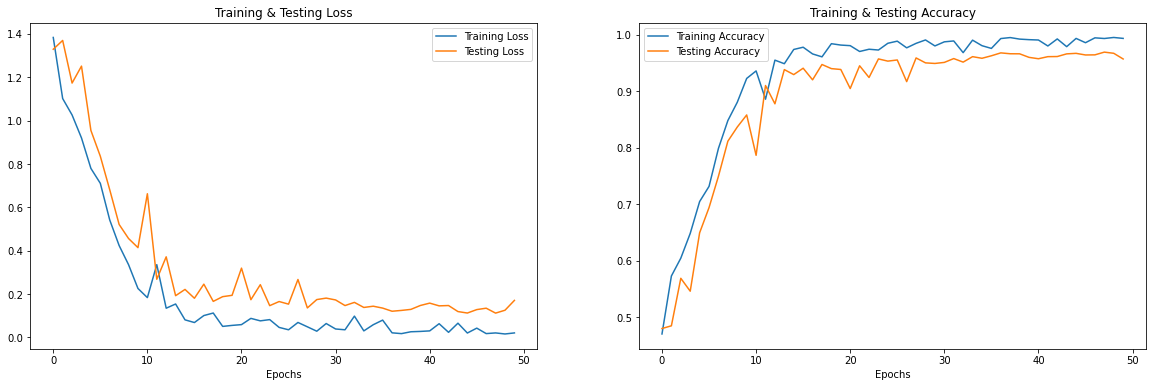

In [49]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [50]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


# CLSTM Model

# Evalutation

Results of best model

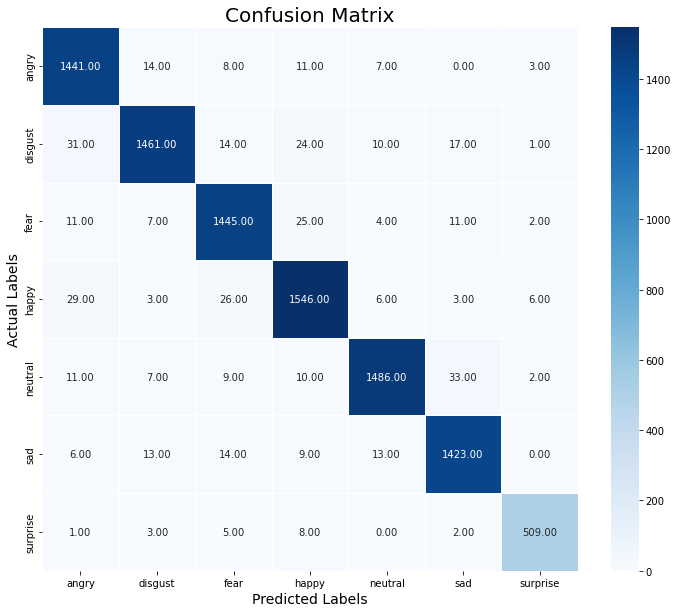

              precision    recall  f1-score   support

       angry       0.94      0.97      0.96      1484
     disgust       0.97      0.94      0.95      1558
        fear       0.95      0.96      0.96      1505
       happy       0.95      0.95      0.95      1619
     neutral       0.97      0.95      0.96      1558
         sad       0.96      0.96      0.96      1478
    surprise       0.97      0.96      0.97       528

    accuracy                           0.96      9730
   macro avg       0.96      0.96      0.96      9730
weighted avg       0.96      0.96      0.96      9730



In [58]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model


# Save Entire Model for FastAPI
The following cell saves the entire model (architecture + weights) to a single HDF5 file. This is the file you'll want to download from Kaggle to use in your FastAPI application.


In [ ]:

# Save the entire model to a single HDF5 file
model.save('Emotion_Voice_Detection_Model.h5')
print("Entire model saved to Emotion_Voice_Detection_Model.h5")


# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [62]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


In [ ]:
# Export model files for FastAPI
import os
import shutil

# Create directory for FastAPI model files
fastapi_model_dir = "./FastAPIApp/model/"
os.makedirs(fastapi_model_dir, exist_ok=True)

# 1. Save the complete model (already done above, but copying to FastAPI directory)
model.save(os.path.join(fastapi_model_dir, 'Emotion_Voice_Detection_Model.h5'))
print("✓ Complete model saved for FastAPI")

# 2. Save scaler and encoder for FastAPI
with open(os.path.join(fastapi_model_dir, 'scaler.pickle'), 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler saved for FastAPI")

with open(os.path.join(fastapi_model_dir, 'encoder.pickle'), 'wb') as f:
    pickle.dump(encoder, f)
print("✓ Encoder saved for FastAPI")

# 3. Alternative: Save model architecture and weights separately (optional)
model_json = model.to_json()
with open(os.path.join(fastapi_model_dir, "CNN_model.json"), "w") as json_file:
    json_file.write(model_json)
print("✓ Model architecture (JSON) saved")

model.save_weights(os.path.join(fastapi_model_dir, "CNN_model.weights.h5"))
print("✓ Model weights saved")

print("\n🎉 All files exported successfully for FastAPI!")
print("Required files for FastAPI:")
print("- Emotion_Voice_Detection_Model.h5 (complete model)")
print("- scaler.pickle (for feature preprocessing)")
print("- encoder.pickle (for label decoding)")
print("\nOptional files (alternative loading method):")
print("- CNN_model.json (model architecture)")
print("- CNN_model.weights.h5 (model weights)")